<a href="https://www.kaggle.com/code/arthurcoss/clip-model?scriptVersionId=118595648" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


tfk = tf.keras
tfkl = tf.keras.layers
AUTOTUNE = tf.data.AUTOTUNE
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.6.4


# Parameters

In [3]:
vocab_size = 20000
sequence_length = 32


image_size = (128,128)
patch_size = 8  
num_patches = (image_size[0] // patch_size) ** 2
projection_dim = 64
input_shape = (128, 128, 3)

learning_rate = 0.001
epochs = 100  # In practice, use ~100 epochs
batch_size = 5

path2img = '/kaggle/input/clip-dataset/resized_train/resized_train/'
path2caption = '/kaggle/input/clip-dataset/caption_prediction_train.csv'

# Image Encoder

What is missing?
* -train val split
* -a better dataloader

In [4]:
data_augmentation = tfk.Sequential(
    [
        tfkl.Normalization()
    ],
    name="data_augmentation",
)

2023-02-08 16:37:59.410378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 16:37:59.411341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 16:37:59.535832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 16:37:59.536656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 16:37:59.537431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
class Patches(tfkl.Layer):
    # Custom Layer to extract patches from images
    # patch_size: size of the patches to be extracted
    def __init__(self, patch_size, **kwargs):
        # Initialize the layer
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        # Extract patches from images
        # images: 4D tensor of shape (batch_size, height, width, channels)
        batch_size = tf.shape(images)[0]
        
        # Extracts patches from the images tensor and returns a 4D tensor
        # shape (batch_size, num_patches, patch_height, patch_width, channels)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        # Get patch dimension
        patch_dims = patches.shape[-1]
        
        # Reshape the patches to have shape (batch_size, num_patches, patch_height * patch_width * channels)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Vanilla ViT

In [6]:
class PatchEncoder(tfkl.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = tfkl.Dense(units=projection_dim)
        self.position_embedding = tfkl.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # Project the patch into a lower-dimensional space
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Add position embedding to the encoded patch
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [7]:
def transformer_block(x, heads, key_dim, units, dropout_rate, name=''):

    # normalize the input
    x1 = tfkl.LayerNormalization(epsilon=1e-6)(x)
    # apply multi-head attention to the normalized input
    attention_output, attention_weights = tfkl.MultiHeadAttention(
        num_heads=heads, 
        key_dim=key_dim, 
        dropout=dropout_rate, 
        name=name+'att'
    )(x1, x1, return_attention_scores=True)
    # apply dropout to the attention output
    attention_output = tfkl.Dropout(dropout_rate)(attention_output)
    # add the attention output to the original input
    x2 = tfkl.Add()([attention_output, x1])
    # normalize the result of the addition
    x3 = tfkl.LayerNormalization(epsilon=1e-6)(x2)    
    # apply a dense layer with the gelu activation function
    x3 = tfkl.Dense(units, activation=tf.nn.gelu)(x3)
    # apply dropout to the dense layer output
    x3 = tfkl.Dropout(dropout_rate)(x3)
    # add the dense layer output to the result of the addition
    x3 = tfkl.Add()([x3, x2])

    return x3, attention_weights

In [8]:
def get_visual_transformer(
    blocks, 
    heads, 
    key_dim, 
    units, 
    num_patches, 
    projection_dim, 
    dropout_rate=0.33
    ):
    
    inputs = tfkl.Input(shape=input_shape, name='inputs')
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for b in range(blocks):
        encoded_patches, attention_weights = transformer_block(
            encoded_patches, 
            heads, 
            key_dim, 
            units,
            dropout_rate,
            name='block'+str(b)+'_'
        )
    
    # Create a [batch_size, projection_dim] tensor
    representation = tfkl.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tfkl.Flatten()(representation)
    representation = tfkl.Dropout(0.5)(representation)
    # Classify outputs
    logits = tfkl.Dense(num_classes)(representation) #num_classes = dim of latent representation of image
    # Create the Keras model
    model = tfk.Model(inputs=inputs, outputs=logits)
    return model

What we want is a latent representation of an image.

now the output of the encoder is (None, 256, 64) which is (bz, num of patches, dim of embeding for each patch)

we try to  

In [9]:
num_classes=64
visual_encoder = get_visual_transformer(
    blocks=4,
    heads=4,
    key_dim=projection_dim,
    units=projection_dim,
    projection_dim=projection_dim,
    num_patches=num_patches
)

In [10]:
visual_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 128, 128, 3)  7           inputs[0][0]                     
__________________________________________________________________________________________________
patches (Patches)               (None, None, 192)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 256, 64)      28736       patches[0][0]                    
______________________________________________________________________________________________

# Text Encoder


In [11]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [12]:
embed_dim = 64 # Embedding size for each token
latent_dim = 1024 # Dimention of the latent space
num_heads = 4 # Number of attention heads

encoder_inputs = tfk.Input(shape=(sequence_length), dtype="int64", name="encoder_inputs")
# Adding token and position embedding layer
x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# Adding transformer encoder block
encoder_outputs = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
# Defining the encoder model
# Apply global average pooling
x = tfkl.GlobalAveragePooling1D()(encoder_outputs)
# Apply dropout
x = tfkl.Dropout(0.5)(x)
# Add a dense layer with softmax activation
outputs = tfkl.Dense(64, activation="relu")(x)
text_encoder = tfk.Model(encoder_inputs, outputs)
# Print the summary of the encoder model
text_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 32)]              0         
_________________________________________________________________
token_and_position_embedding (None, 32, 64)            1282048   
_________________________________________________________________
transformer_encoder_block (T (None, 32, 64)            198784    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
Total params: 1,484,992
Trainable params: 1,484,992
Non-trainable params: 0
_________________________________________________

In [13]:
class CLIP(tfk.Model):
    def __init__(self, textEncoder, imageEncoder):
        super().__init__()
        self.textEncoder = textEncoder
        self.imageEncoder = imageEncoder

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_tracker = tfk.metrics.Mean(name="loss")
        
    @property
    def metrics(self):
        return [self.loss_tracker]        
    
    def call(self, features, training=False):
        with tf.device("/gpu:0"):
            caption_embeddings = self.textEncoder(features[1], training=training)
        with tf.device("/gpu:1"):
            image_embeddings = self.imageEncoder(features[0], training=training)
        return caption_embeddings, image_embeddings
    
    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = tfk.activations.softmax(captions_similarity + images_similarity)
        # Compute the loss for the captions using crossentropy
        captions_loss = tfk.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = tfk.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, images_captions):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(images_captions, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, images_captions):
        caption_embeddings, image_embeddings = self(images_captions, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Data Pre processing

In [14]:
data = pd.read_csv(path2caption,header=0, sep='\t')

vectorise = tfkl.TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
vectorise.adapt(data['caption'])

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    return img

def process_input(links,captions):
    return decode_and_resize(path2img+links+'.jpg'), captions
    
def make_dataset(data):   
    dataset = tf.data.Dataset.from_tensor_slices((data['ID'], vectorise(data['caption'])))
    dataset = dataset.shuffle(batch_size * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    
    return dataset


data = data.iloc[:100]
train_dataset = make_dataset(data.iloc[:75])
valid_dataset = make_dataset(data.iloc[75:100])

2023-02-08 16:38:05.039633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [18]:
contrast_model = CLIP(text_encoder,visual_encoder)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
optimizer = tfk.optimizers.Adam(learning_rate)

contrast_model.compile(optimizer)


history = contrast_model.fit(train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)

visual_encoder.save("vision_encoder")
text_encoder.save("text_encoder")

Epoch 1/100
15/15 [==============================] - 6s 92ms/step - loss: 10.3180 - val_loss: 1.7562
Epoch 2/100
15/15 [==============================] - 1s 45ms/step - loss: 10.2169 - val_loss: 1.6094
Epoch 3/100
15/15 [==============================] - 1s 46ms/step - loss: 6.9582 - val_loss: 1.6094
Epoch 4/100
15/15 [==============================] - 1s 44ms/step - loss: 6.1231 - val_loss: 1.6094
Epoch 5/100
15/15 [==============================] - 1s 45ms/step - loss: 7.1426 - val_loss: 1.6094
Epoch 6/100
15/15 [==============================] - 1s 63ms/step - loss: 4.6943 - val_loss: 1.6094
Epoch 7/100
15/15 [==============================] - 1s 45ms/step - loss: 4.3348 - val_loss: 1.6094


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


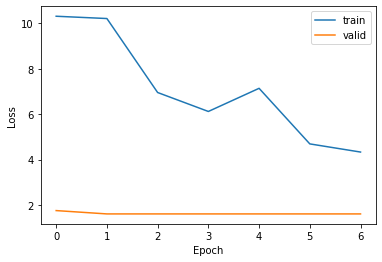

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()
